<a href="https://colab.research.google.com/github/kanavgoyal781/Gen_Ai/blob/Step-1-Choose_a_Model/Fine_Tuning_LLMs_with_QLoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

In [ ]:
# Install core dependencies for LoRA + supervised fine-tuning (SFTTrainer setup)
%pip install -q --upgrade \
  transformers \
  datasets \
  peft==0.8.2 \
  accelerate \
  bitsandbytes \
  trl==0.8.6 \
  wandb \
  evaluate \
  rouge_score


In [ ]:
from huggingface_hub import login
login()  # Then paste your updated access token

In [ ]:
!pwd

In [ ]:
!pip install nbstripout
!nbstripout /content/Fine_Tuning_LLMs_with_QLoRA.ipynb

Step1

In [12]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType
import torch
from transformers import BitsAndBytesConfig

### 📦 Library Imports
- **AutoModelForCausalLM**: From Hugging Face’s Transformers; loads a pre‑trained causal language model (e.g., Mistral, LLaMA).
- **AutoTokenizer**: Loads the matching tokenizer for the model (handles text → tokens).
- **LoraConfig**: Defines LoRA adapter parameters (e.g., rank, alpha, dropout).
- **get_peft_model**: Applies the LoRA adapters to the base model.
- **TaskType**: Specifies what kind of task LoRA is applied for (e.g., Causal LM).
- **torch**: Core PyTorch library for tensors and GPU computation.
- **BitsAndBytesConfig**: Configures 4‑bit quantization via `bitsandbytes` (reduces memory).

In [13]:
model_name = "mistralai/Mistral-7B-v0.1"

### 🎯 Model Selection
- **model_name**: The Hugging Face ID of the model we want to load.
- Here we selected **Mistral‑7B**, a 7‑billion parameter model, fully compatible with LoRA.

In [15]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

### 🔤 Tokenizer Deep Dive – Padding, EOS, and Why We Use EOS for Padding

A **tokenizer** converts raw text into token IDs (numbers) that a model understands. Every model (Mistral, Falcon, LLaMA, etc.) has its **own** tokenizer, because each was trained on a different vocabulary and segmentation scheme. Using the wrong tokenizer with a model will produce meaningless inputs.

---

#### 📏 Padding: Making All Sequences the Same Length
Models train and infer on **batches** of sentences. All sentences in a batch must have the **same length**:

- **Sentence A**: “LoRA is great!” → 4 tokens  
- **Sentence B**: “LoRA works”     → 2 tokens  

To batch them, you **fill** the shorter one with extra tokens:
50256, 318, 1334, 2]   ← Sentence A

[50256, 293,    2, 2]   ← Sentence B + padding


That filler token is called **padding**.

---

#### 🚪 EOS Token: “End-of-Sentence”
- The **EOS token** (e.g. ID `2`) signals **“the text stops here.”**  
- In generation, when the model emits `<EOS>`, it stops.  
- In training, `<EOS>` marks the true end of each sequence.

---

#### ⚠️ Models Without a Pad Token
Many large models (Mistral, LLaMA) were trained **without** a dedicated pad token and will error if you batch without one:
ValueError: Tokenizer does not have a pad token

Or they may use random IDs for padding, corrupting training.

---

#### ✅ Reusing EOS as Pad Token
```python
tokenizer.pad_token = tokenizer.eos_token


### 🔍 Why We Set `tokenizer.pad_token = tokenizer.eos_token`

Many modern causal language models (like **Mistral** or **LLaMA**) do **not** come with a dedicated padding token. This single line:

```python
tokenizer.pad_token = tokenizer.eos_token


fixes that gap by reusing the model’s End-of-Sentence (EOS) token as its Padding token.

❗ The Problem
	•	Models process inputs in batches, but not all sentences are the same length.
	•	Example:

  "LoRA is great!" → 4 tokens
"LoRA works"     → 2 tokens

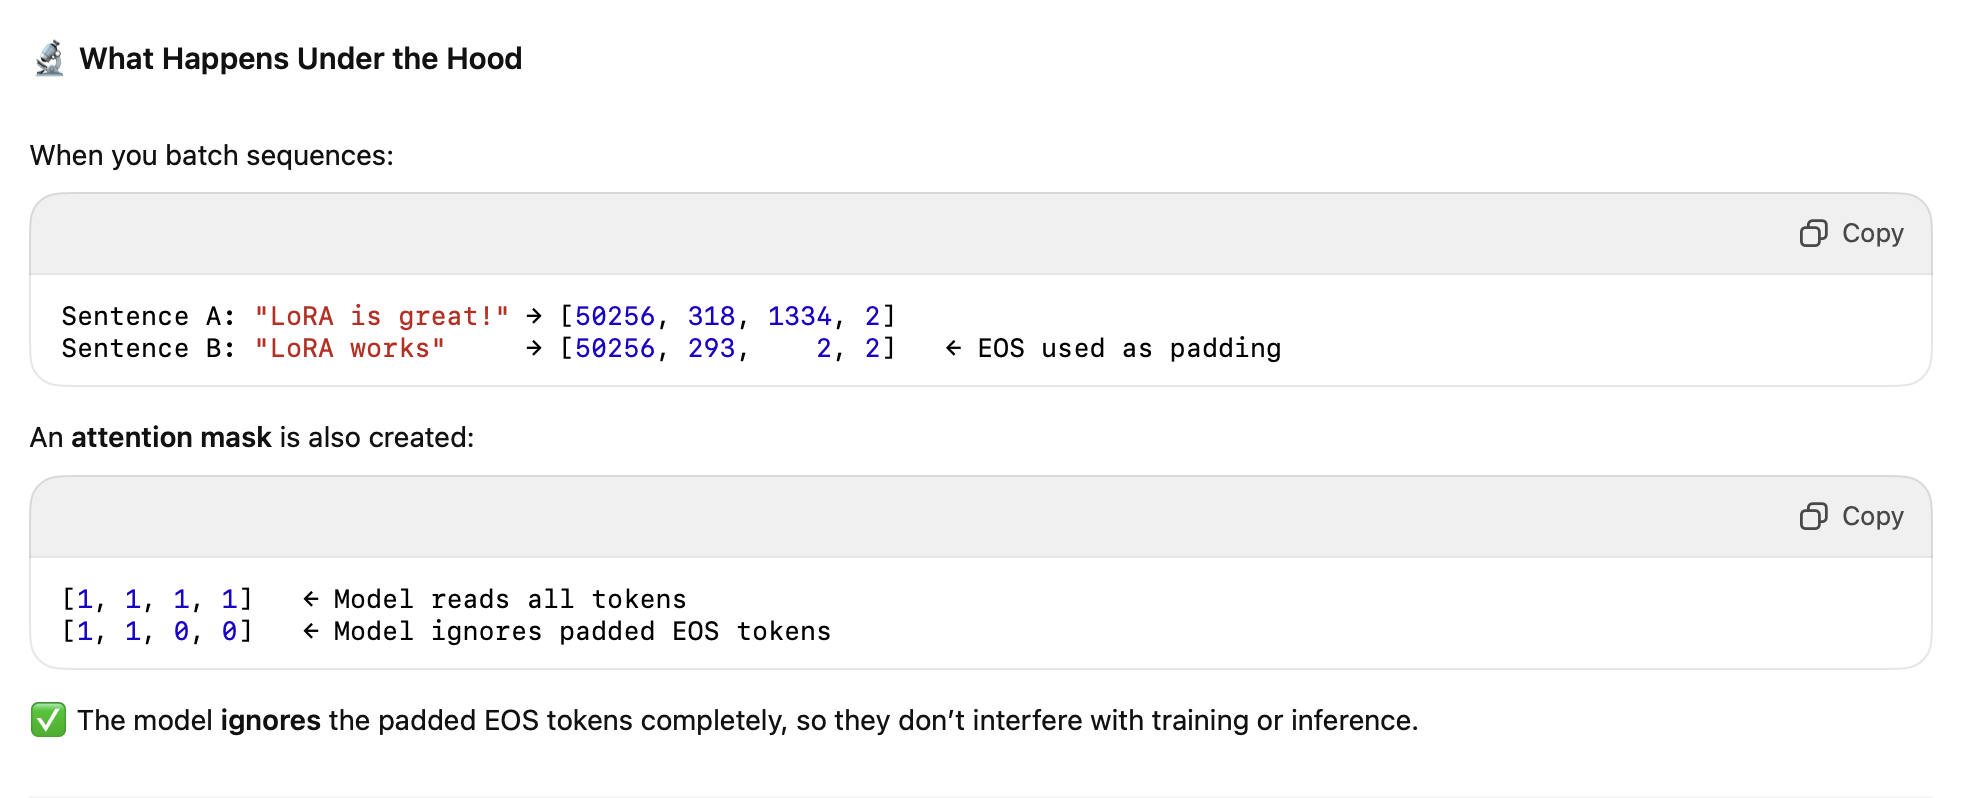




🚀 Why This Works Perfectly
	•	EOS is a “neutral” token: the model already knows it means “end of text,” so reusing it doesn’t create confusion.
	•	Attention masks handle the rest: padding EOS is skipped entirely.
	•	Industry standard: Hugging Face, Meta (for LLaMA), and QLoRA tutorials all recommend this approach.

### 🔤 Tokenizer Setup
- **AutoTokenizer.from_pretrained(model_name)**: Downloads the correct tokenizer for Mistral‑7B.
- **tokenizer.pad_token = tokenizer.eos_token**: Sets the padding token to be the same as the end‑of‑sentence (EOS) token.  
  This avoids padding errors during fine‑tuning since some models don’t define a pad token by default.

In [18]:
# quantization Config

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                   # 4-bit quantization
    bnb_4bit_use_double_quant=True,       # enable double quantization
    bnb_4bit_quant_type="nf4",            # use NF4 quantization (best quality) / 1.75 → normalize (normal (Gaussian) curve)  → 1.2 → nearest NF4 value → 1.1 → 4-bit code

    bnb_4bit_compute_dtype=torch.bfloat16 # compute in bfloat16 or float16.  / bfloat16 handles bigger numbers, float16 is more precise.

)

### ⚙️ Quantization Config – `BitsAndBytesConfig`

We use `BitsAndBytesConfig` from the **bitsandbytes** library to load the model in **4‑bit precision**.  
This dramatically reduces VRAM usage and makes it possible to fine‑tune large models like Mistral‑7B on smaller GPUs.

#### 🔢 `load_in_4bit=True`
- Loads the model weights in **4‑bit precision** instead of the usual 16‑bit or 32‑bit.  
- ✅ **Why we use it:**  
   - Shrinks the model’s memory footprint by **70–80%**.  
   - A 7B model can drop from ~28GB → ~4–5GB VRAM.  
   - Makes fine‑tuning possible on **Colab GPUs** like T4 or A100.

#### 🎯 `bnb_4bit_use_double_quant=True`
- Enables **double quantization**.
- ✅ **How it works:**  
   1. Model weights are first compressed from 32‑bit to **8‑bit**.  
   2. Then they’re quantized again to **4‑bit**.  
- ✅ **Why it’s helpful:**  
   - Preserves more accuracy than jumping straight to 4‑bit.  
   - Keeps the model closer to full‑precision behavior while saving memory.

#### 📐 `bnb_4bit_quant_type="nf4"`
- Uses **NF4 (NormalFloat4)** as the quantization format.  
- ✅ **What NF4 does:**  
   - Normalizes weights (maps them to a Gaussian curve).  
   - Each weight is rounded to the closest NF4 code.  
- ✅ **Why NF4:**  
   - It’s the **highest‑quality** 4‑bit format for LLMs.  
   - Retains more performance vs. simpler formats like FP4.

#### 🖥️ `bnb_4bit_compute_dtype=torch.bfloat16`
- Tells the model to **do math** in **bfloat16** (Brain Floating Point 16).  
- ✅ **Why bfloat16:**  
   - Has a **wider numeric range** than float16 (avoids overflow).  
   - Stable for training large models.  
   - Optimized for modern GPUs (A100, H100, TPUs).

### 📌 Why This Config Matters
By combining these options, we:
1. Load the model in **4‑bit** for huge memory savings.  
2. Use **NF4** + **double quantization** to keep accuracy high.  
3. Do all math in **bfloat16** for speed and stability.  

✅ **Result:** We can fine‑tune a massive 7B model like Mistral on a single Colab GPU — something impossible at full precision.

In [19]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config
)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### 🏗 Loading the Base Model

We use `AutoModelForCausalLM.from_pretrained()` from Hugging Face to load our base model (e.g., Mistral‑7B).  
This step brings the model into memory, applies 4‑bit quantization, and maps it to the GPU automatically.


#### 📦 `model_name`
- Tells Hugging Face which model to load.  
- Example: `"mistralai/Mistral-7B-v0.1"`.
- Each Hugging Face model repo has its own ID — this ensures we pull the correct weights and architecture.



#### ⚙️ `device_map="auto"`
- Hugging Face automatically assigns model layers to available hardware:
  - ✅ GPU if available
  - ❗ CPU if GPU memory is full
- This makes it possible to run even huge models by “sharding” parts across devices.

#### 🔐 `trust_remote_code=True`
- Allows execution of **custom model code** from the Hugging Face repo.
- Why we need it:
  - Some models (like Mistral, Falcon) don’t just use the default `transformers` code — they have **custom architectures**.
  - Without this flag, loading would fail for these models.
- Safety note: Only use this with **trusted** repos like Hugging Face official or well‑known teams.


#### 🧮 `quantization_config=bnb_config`
- Applies our **BitsAndBytesConfig** (4‑bit quantization) while loading the model.
- This means:
  - The model’s weights are loaded directly in **4‑bit**.
  - We save a huge amount of VRAM from the start.
- Without this, the model would load in full 16‑bit or 32‑bit precision — likely too big for Colab GPUs.

In [20]:
# Inject LoRA adapters
lora_config = LoraConfig(
    r=8,  #  LoRA rank — defines the "depth" of the low-rank update.
          # Think of it as a bottleneck: it controls how much capacity
          # the adapter layers have to learn new behavior.
          # Higher r = more expressive updates, but more compute.

    lora_alpha=16,  #  Scaling factor for the LoRA update.
                    # The LoRA output is scaled by (alpha / r).
                    # This prevents the adapter update from overwhelming the frozen weights.
                    # In this case: scale = 16 / 8 = 2.0 → moderate influence.

    target_modules=["q_proj", "v_proj"],  # Mistral models have separate Q and V projections.
                                          # We inject LoRA adapters into both parts.

    lora_dropout=0.05,  # Apply dropout before the LoRA update for regularization.

    bias="none",  # We're not adapting any bias terms — only the LoRA adapters are trainable.

    task_type=TaskType.CAUSAL_LM  # Language modeling task (next-token prediction)
)

### 🔌 Injecting LoRA Adapters

We create a `LoraConfig` to define how **LoRA adapters** will be added to the base model.  
LoRA (Low-Rank Adaptation) lets us **fine-tune** a huge model (like Mistral‑7B) by training only a few million parameters instead of all billions.

---

#### 🔢 `r=8`
- **LoRA rank** — defines the “depth” of the low-rank update.  
- Think of it as the **bottleneck size**:  
  - Higher `r` = more capacity to learn, but more GPU memory needed.  
  - Lower `r` = cheaper but less expressive.  
- Here `r=8` is a common sweet spot: light on memory, good quality.

---

#### ⚖️ `lora_alpha=16`
- **Scaling factor** for LoRA updates.  
- LoRA computes an update and scales it by `(alpha / r)`.  
- With `16/8 = 2.0`, the adapter’s influence is balanced — not too weak, not overpowering the frozen weights.

---

#### 🎯 `target_modules=["q_proj", "v_proj"]`
- Tells LoRA **which layers** to modify.  
- Mistral (and LLaMA-style models) have **query (Q)** and **value (V)** projection layers inside each attention block.  
- We inject LoRA adapters **into Q and V only** — this is efficient and proven to work well.

---

#### 💧 `lora_dropout=0.05`
- Adds **5% dropout** to LoRA adapters during training.  
- Helps prevent **overfitting** by randomly disabling some adapter connections on each step.

---

#### 🚫 `bias="none"`
- Means we **do NOT fine-tune any bias terms** in the model.  
- Only the LoRA adapter weights are trainable.  
- ✅ This keeps the fine-tuning extremely **lightweight**.

---

#### 📚 `task_type=TaskType.CAUSAL_LM`
- Specifies that this model is for **causal language modeling** (next-token prediction).  
- Ensures LoRA integrates correctly into a generative model like Mistral.

---

### 📌 Why This Config Matters
This `LoraConfig` defines **how** and **where** LoRA adapters attach to Mistral:

- **r=8** → small, efficient adapter size.  
- **alpha=16** → balanced scaling.  
- **Q/V projection layers only** → proven best practice for LLaMA/Mistral models.  
- **dropout** and **no bias** → regularized, lightweight training.  

✅ **Result:** We can fine‑tune Mistral‑7B by training **only the adapters** — not all 7B parameters — saving massive compute.

In [21]:
print("quantization  model loaded with LoRA adapters applied.")

# Inject LoRA into the model
model = get_peft_model(model, lora_config)

# Print which parameters are trainable (you'll see only LoRA adapters)
model.print_trainable_parameters()

quantization  model loaded with LoRA adapters applied.
trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.04703666202518836


In [22]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear4bit(in_features=4096, out_features=1024, bias